<a href="https://colab.research.google.com/github/kode-git/ViT-FER/blob/main/ViT_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Face Emotion Recognition


## 1. Introduction


ViT Face Emotion Recognition is a project based on the use of transformers for image classification. Our project demonstrated that transformers could classify some images in tasks like emotion recognition. The project has three different datasets in input that must merge into one homogeneous dataset. Firstly, we need to resize images using a 224x224 total dimension because transformers have the same linear size for the input and the patching phase needs the same amount of data. The result subsets must merge on one dataset called ViT. 

ViT Dataset has eight different classes integrated by three different subsets:
1. FER-2013: Fer2013 contains approximately 30,000 facial RGB images of different expressions with a size restricted to 48×48, and the main labels can be split into seven types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has a minimal number of images – 600, while other labels have nearly 5,000 samples each.
2. CK+: The Extended Cohn-Kanade (CK+) dataset contains images extrapolated from 593 video sequences from 123 different subjects, ranging from 18 to 50 years of age with a variety of genders and heritage. Each video shows a facial shift from the neutral expression to a targeted peak expression, recorded at 30 frames per second (FPS) with a resolution of either 640x490 or 640x480 pixels. Unfortunately, we do not have all generated datasets, but we stored only 1000 images with high variance from a Kaggle repository. 
3. AffectNet: It is a sizeable facial expression dataset with 40k images classified in eight categories (neutral, happy, angry, sad, fear, surprise, disgust, contempt) of facial expressions along with the intensity of valence and arousal.

Each dataset focuses on RGB channels for the colouring and has different sizes and image extensions entirely stored in Google Drive (the total amount of data is around 2 GB). So, we need to establish a standard format to manage them simultaneously. Finally, we will pass in a data augmentation phase to improve the total amount of images to balance the number of samples for each category. 

Finally, we have the final sections interested in the fine-tuning phase and training on a few models that can be saved locally on the drive and used in an external application for real-time classification on an ad-hoc application. More information about modelling is in the following sections.

## 2. Data Retrieval

### 2.1 Import Libraries and Utility class

In [1]:
!pip3 install Pillow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
#import keras
import  os, cv2, glob
#from google.colab import drive

In [3]:
from PIL import Image

Data sources about datasets described in the previous section are in Google Drive, so we need to manage files in a shared directory and integrate them into a single unit by merging images of the same classes from different datasets.

Loading data from the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following snippet of code describes essential functions used for the integration; ImageWorker is a class that we can use to convert the size format of an image (to make them in a standard dimension), change the extension of an image and can evaluate the number of images per class in each of exciting datasets.

In [5]:
class ImageWorker():

    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_type, dest_path):
        """format_converter : void

        Args:
            path (str): The source path of the images folder 
            format (str): Format of the images in the folder
            source_type (str): Type of the dataset 
            dest_path (str): Destination path to store resized images
        """        
        count = 0

        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
            print('Resized writing for', dest_path + "resized_on_" + source_type + "_" + str(count) + "." + format_img )
            cv2.imwrite(dest_path + "resized_on_" + source_type + "_" + str(count) + "."+ format_img, resized)
            count += 1


    def list_classes(self, dataset_path):
        """list_classes : list

        Args:
            abs_path (str): Absolute Path with marker for the listing classes on a dataset folder
        """   
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """counter_samples_on_class : dict

        Args:
            dataset_path (str): Absolute Path with marker for the listing classes on a dataset folder
      """   
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
     """counter_samples : int

        Args:
            dataset_path (str): Absolute Path with marker for the listing classes on a dataset folder
     """ 
     a = self.counter_samples_on_class(dataset_path)
     counter = 0
     for el in a.keys():
       counter += a[el]
     return counter



    def extension_converter(self, path, format_source, format_result, dest_path):
      """extension_converter : void

        Args:
            path (str): The source path of the images folder 
            format_source (str): Extension of the images in the folder
            format_result (str): Extension of the result image
            dest_path (str): Destination of the result image
        """        

        # WARNING: During the convertion, we will delete the file with the format_source from the directory
        # specified by the path
       
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """counter_file_extension : int

        Args:
            path (str): The source path of the images folder 
            format(str): Extension of the file counting
        """     

      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      
    def navigate_path(self, path):
        """navigate_path : int

        Args:
            path (str): Path to navigate and counting number of files

        Returns:
            int : the total amount of file in the directory specified by the path
        """        
        count = 0
        for dir in os.listdir(path):
            if os.path.isfile(os.path.join(path, dir)):
                count += 1
        return count

iw = ImageWorker()

### 2.2 FER2013 Dataset
FER2013 is a dataset composed of 20.000 images in 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class was missed on this kind of dataset.

In [35]:
num_classes = 7

data_train_fer = '/content/drive/My Drive/Datasets/FER-2013/train/*'
data_val_fer = '/content/drive/My Drive/Datasets/FER-2013/val/*'

fer_classes_t = iw.list_classes(data_train_fer)
fer_classes_v = iw.list_classes(data_val_fer)

In [36]:
fer_classes_t

['happy', 'fear', 'sad', 'disgust', 'surprise', 'neutral', 'anger']

In [37]:
fer_classes_v

['fear', 'disgust', 'happy', 'neutral', 'surprise', 'sad', 'anger']

In [38]:
fer_train_tot = iw.counter_samples(data_train_fer)
fer_val_tot = iw.counter_samples(data_val_fer)
fer_tot = fer_train_tot + fer_val_tot
print("Total no. of images in FER: ", fer_tot)
print("Total no. of train images in FER:", fer_train_tot)
print("Total no. of val images in FER:", fer_val_tot)

Total no. of images in FER:  35953
Total no. of train images in FER: 28775
Total no. of val images in FER: 7178


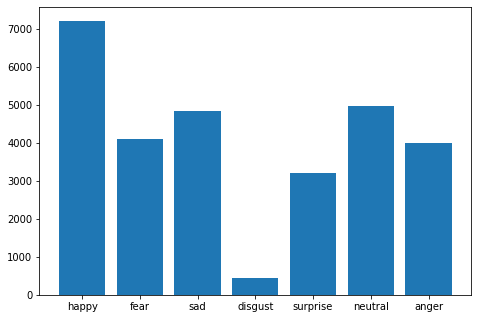

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = fer_classes_t
count_dict_fert = iw.counter_samples_on_class(data_train_fer)
x_1 = [count_dict_fert[cl] for cl in count_dict_fert.keys()]
ax.bar(langs, x_1)
plt.show()

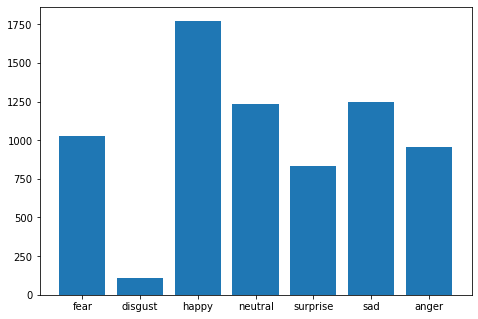

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = fer_classes_v
count_dict_ferv = iw.counter_samples_on_class(data_val_fer)
x_2 = [count_dict_ferv[cl] for cl in count_dict_ferv.keys()]
ax.bar(langs, x_2)
plt.show()

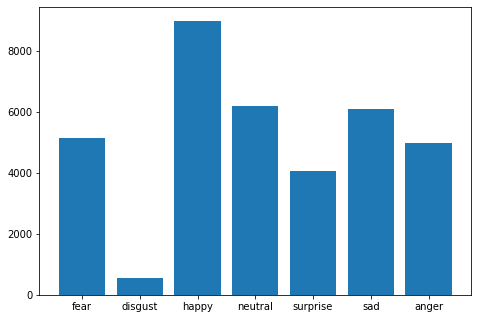

In [41]:
tot_cl={}
for cl in count_dict_ferv.keys():
  tot_cl[cl] = count_dict_ferv[cl] + count_dict_fert[cl]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = tot_cl.keys()
x_tot = [tot_cl[cl] for cl in langs]
ax.bar(langs, x_tot)
plt.show()

FER2013 do not have many samples for the disgust class. This observation guarantees an excellent motivation to merge it with other datasets and the data augmentation phase. Furthermore, it is unbalanced, and we need to manage it in data augmentation or data integration with some samples from other datasets to make a result set with the same number of samples for each class.

70


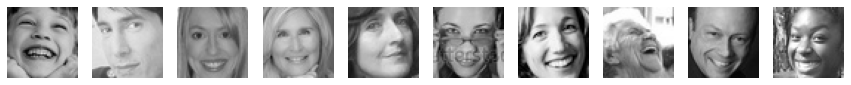

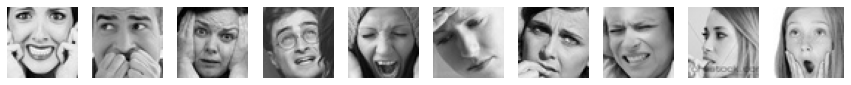

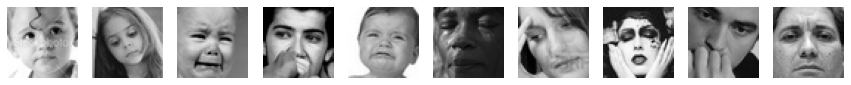

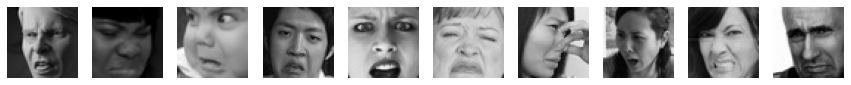

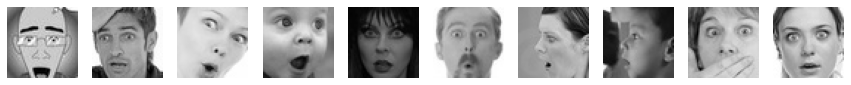

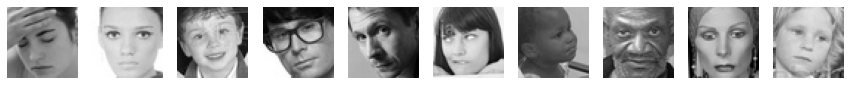

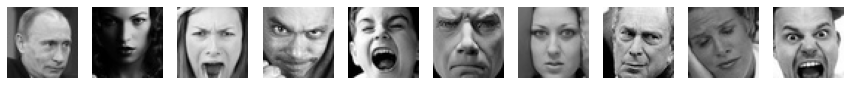

In [42]:
paths = []
for path in glob.glob("/content/drive/MyDrive/Datasets/FER-2013/train/*"):
  paths.append(path + "/*.jpg")

results = []
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')


This dataset is pretty good in terms of data views, with some variance in the patterns given by a significant variability of facial expressions for each category. The image size is 48x48; we need to resize it to 224x224 size and put it together in the same folder as the other datasets for data integration. We will use our ImageWorker object to do that.

In [62]:
format_fer = "jpg"
source_type = "fer_2013"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in fer_classes_t]
sources = ["/content/drive/MyDrive/Datasets/FER-2013/train/" + class_ for class_ in fer_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3970.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3971.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3972.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3973.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3974.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3975.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3976.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3977.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3978.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_3979.jpg
Resized writing for

The data integration phase did not distinguish between train and test splitting. So, we can merge the FER-2013 val set with the training set and split it a second time. Our interest is to analyze the val set as well as we did with the training set.

In [63]:
sources = ["/content/drive/MyDrive/Datasets/FER-2013/val/" + class_ + "/" for class_ in fer_classes_t]
source_type = "fer_2013_test"

for i in range(0, len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_404.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_405.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_406.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_407.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_408.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_409.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_410.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_411.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_412.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_fer_2013_test_413.jpg
Resized w

### 2.3  CK+ Dataset
It is a small dataset composed of 981 images in seven classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [64]:
num_classes = 7

data_dir_ck = '/content/drive/My Drive/Datasets/CK+48/*'
ck_classes_t = iw.list_classes(data_dir_ck)
ck_classes_t

['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']

In [65]:
ck_tot = iw.counter_samples(data_dir_ck)
print("Total no. of images in CK+: ", ck_tot)

Total no. of images in CK+:  986


7
70


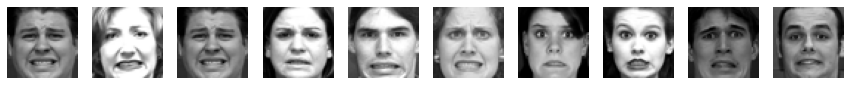

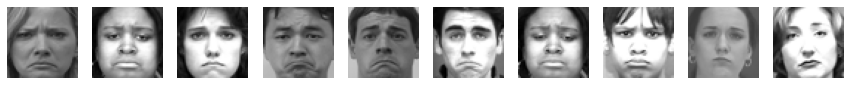

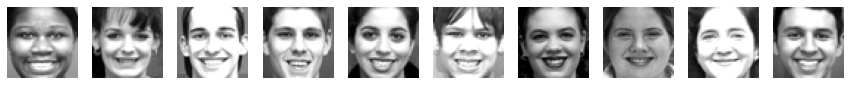

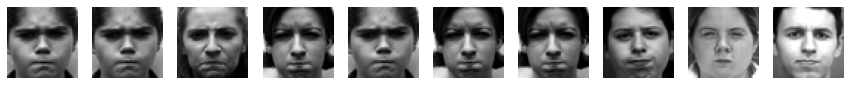

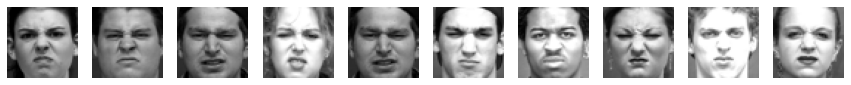

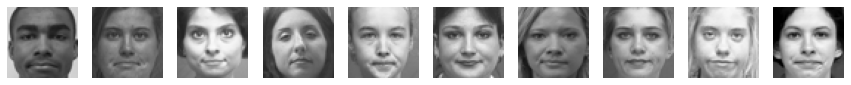

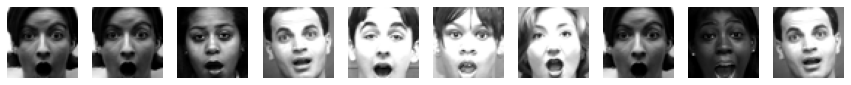

In [66]:
paths = []
for path in glob.glob(data_dir_ck):
  paths.append(path + "/*.png")

results = []
num_classes = len(ck_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

The image size is 48x48. To retrieve some data in a standard format, we will try to resize them, maintaining pixels patterns for data processing. The new size is 224x224, which should maintain in a good way features of the samples. We will save the resized images in a new folder on the drive.

In [67]:
ck_classes_t

['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']

In [68]:
format_ck = "png"
source_type = "ck_plus"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in ck_classes_t]
sources = ["/content/drive/MyDrive/Datasets/CK+48/" + class_ for class_ in ck_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_0.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_1.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_2.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_3.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_4.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_5.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_6.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_7.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_8.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_9.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/fear/resized_on_ck_plus_10.png
Resized writing for /content/drive/MyDrive/Datasets/V

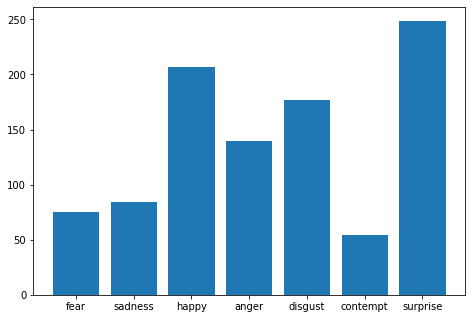

In [70]:
def plot_dataset(dataset_path):
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  ax.bar(classes, x)
  plt.show()

plot_dataset("/content/drive/MyDrive/Datasets/CK+48/*")

### 2.4 AffectNet Dataset
AffectNet dataset has samples of different sizes, high-quality images in grey-scale or coloured in RGB range. It has eight different classes (surprise, angry, sad, contempt, disgust, fear, neutral, and happy). As the FER-2013, there is a division between testing and training set; we will merge it as well as we did with FER subsets. Furthermore, we resize the different sizes of its images in 256x256 to establish the same amount of pixels for each sample.

In [84]:
num_classes = 8

data_train_af = '/content/drive/My Drive/Datasets/AffectNet/train_class/*'
data_val_af = '/content/drive/My Drive/Datasets/AffectNet/val_class/*'

af_classes_t = iw.list_classes(data_train_af)
af_classes_v = iw.list_classes(data_val_af)

In [85]:
af_classes_t

['sad', 'happy', 'surprise', 'neutral', 'fear', 'disgust', 'contempt', 'anger']

In [86]:
af_classes_v

['happy', 'sad', 'surprise', 'fear', 'neutral', 'disgust', 'anger', 'contempt']

In [74]:
af_train_tot = iw.counter_samples(data_train_af)
af_val_tot = iw.counter_samples(data_val_af)
af_tot = af_train_tot + af_val_tot
print("Total no. of images in AffectNet: ", af_tot)
print("Total no. of train images in AffectNet:", af_train_tot)
print("Total no. of val images in AffectNet:", af_val_tot)

Total no. of images in AffectNet:  41591
Total no. of train images in AffectNet: 37591
Total no. of val images in AffectNet: 4000


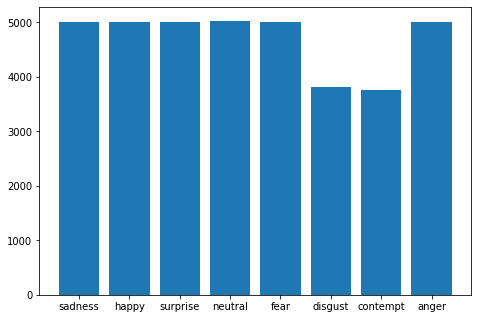

In [75]:
plot_dataset("/content/drive/MyDrive/Datasets/AffectNet/train_class/*")

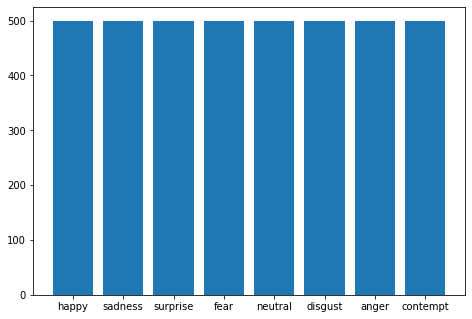

In [76]:
plot_dataset("/content/drive/MyDrive/Datasets/AffectNet/val_class/*")

8
80


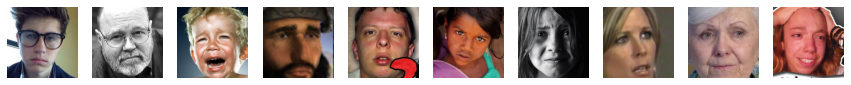

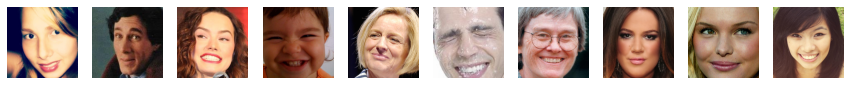

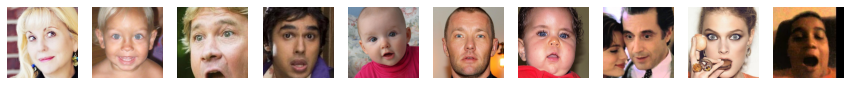

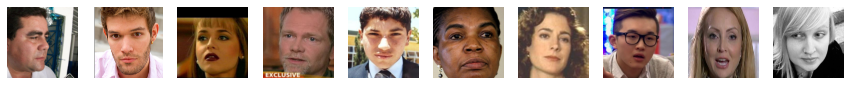

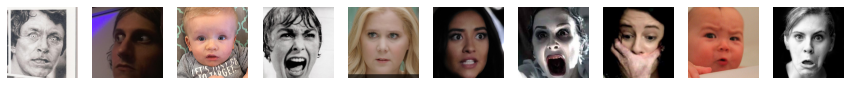

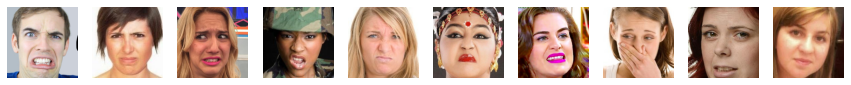

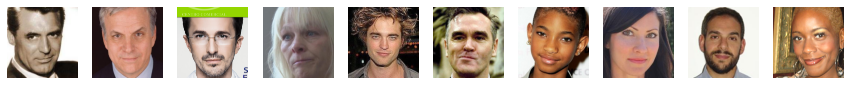

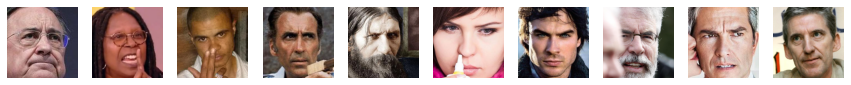

In [77]:
paths = []
for path in glob.glob(data_train_af):
  paths.append(path + "/*.jpg")

results = []
num_classes = len(af_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [87]:
# Format of the image in the AffectNet
format_affectnet = "jpg"
source_type = "affect_net"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class/" + class_ + "/" for class_ in af_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_8.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_9.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_10.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_11.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_12.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_13.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_14.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_15.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_16.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affect_net_17.jpg
Resized writing for /content/drive/MyDriv

In [88]:
source_type = "affectnet_2"

destinations = ["/content/drive/MyDrive/Datasets/ViT/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/val_class/" + class_ for class_ in af_classes_t]

for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])


Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_0.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_1.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_2.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_3.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_4.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_5.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_6.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_7.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_8.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_9.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sad/resized_on_affectnet_2_10.jpg
Resized writing for 

### 2.5 ViT Dataset
ViT is the result dataset composed by integrating images of the three different data sources described in the introduction section. Its composition is a mix of grey-scale and RGB-based images with the exact dimensions divided by subdirectories to divide different classes. We do not have any training/testing splitting yet.

In [89]:
num_classes = 8

data_vit = '/content/drive/My Drive/Datasets/ViT/*'

classes_vit = iw.list_classes(data_vit)
classes_vit

['happy', 'surprise', 'anger', 'sad', 'fear', 'neutral', 'disgust', 'contempt']

In [90]:
vit_tot = iw.counter_samples(data_vit)
print("Total no. of images in ViT:", vit_tot)

Total no. of images in ViT: 78446


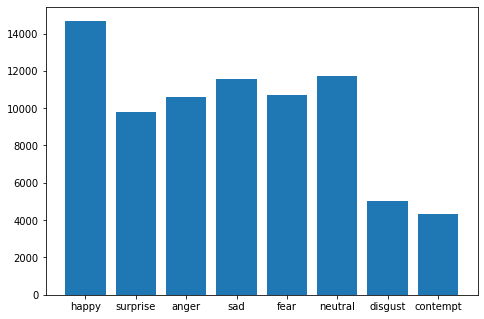

In [91]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT/*")

## 3. Data Analysis


Given the result dataset, we are ready to manage samples with data augmentation and pre-processing procedures to prepare samples for the proposed models.

Firstly, we need to transform images into a standard extension. Data from AffectNet and FER-2013 have JPG images; meanwhile, CK+ has PNG extensions. Considering the total jpg-type images, we will convert every sample into this format.

The total amount of data is 83.017 different samples; categories like Disgust or Contempt are around 5500 and 5800 different samples, respectively. The dataset is unbalanced, so we will execute data augmentation procedures to improve the total number of these categories to solve that.

In [92]:
vit_path = "/content/drive/MyDrive/Datasets/ViT/*"

In [93]:
classes = iw.list_classes(vit_path)
n_classes = len(classes)
print(f'There are {n_classes} classes:', classes)

There are 8 classes: ['happy', 'surprise', 'anger', 'sad', 'fear', 'neutral', 'disgust', 'contempt']


In [94]:
val_c_vit = iw.counter_samples_on_class(vit_path)
print('Number of images per class:', val_c_vit)

Number of images per class: {'happy': 14696, 'surprise': 9797, 'anger': 10611, 'sad': 11577, 'fear': 10706, 'neutral': 11728, 'disgust': 5027, 'contempt': 4304}


In [95]:
print("Total no. of images is", iw.counter_samples(vit_path))

Total no. of images is 78446


In [96]:
categories_data = {}
for class_ in classes:
  categories_data[class_] = {}
  categories_data[class_]["png_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "png")
  categories_data[class_]["jpg_count"] = iw.counter_file_extension(vit_path[0: len(vit_path) - 1] + class_, "jpg")
categories_data

{'anger': {'jpg_count': 10471, 'png_count': 140},
 'contempt': {'jpg_count': 4250, 'png_count': 54},
 'disgust': {'jpg_count': 4850, 'png_count': 177},
 'fear': {'jpg_count': 10631, 'png_count': 75},
 'happy': {'jpg_count': 14489, 'png_count': 207},
 'neutral': {'jpg_count': 11728, 'png_count': 0},
 'sad': {'jpg_count': 11577, 'png_count': 0},
 'surprise': {'jpg_count': 9548, 'png_count': 249}}

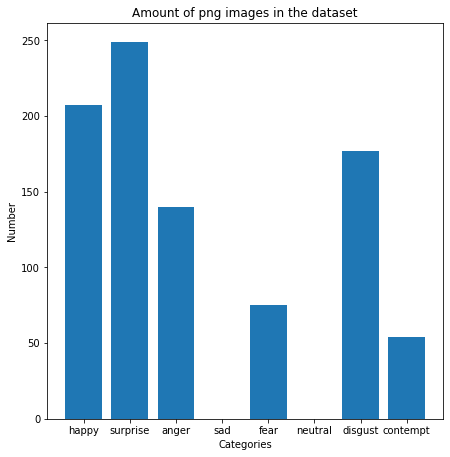

In [97]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of png images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

The total amount of data in png is pretty tiny. That is because we have some samples given by CK+ in this format. CK+ did not focus on many data, so changing these images in .jpg did not impact the dataset noise.


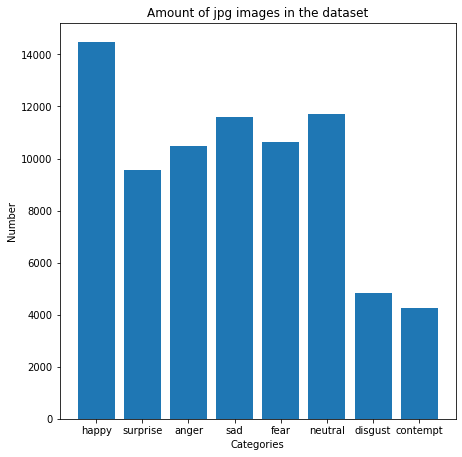

In [98]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count'] for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Amount of jpg images in the dataset')
plt.ylabel('Number')
plt.xlabel('Categories')
plt.show()

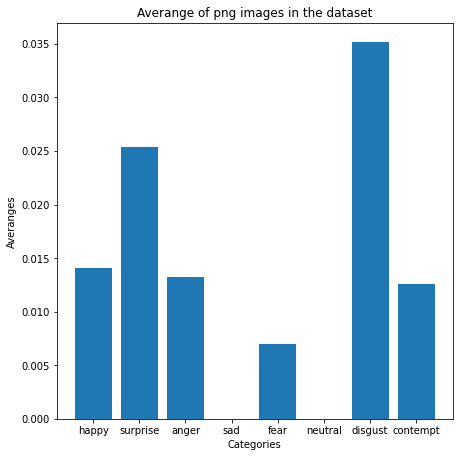

In [99]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['png_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of png images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

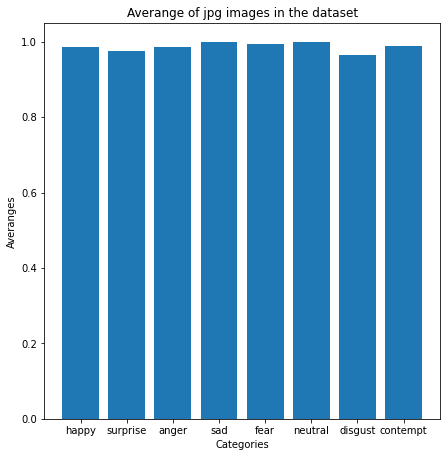

In [100]:
fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_axes([0,0,1,1])
langs = [el for el in categories_data.keys()]
x = [categories_data[el]['jpg_count']/(categories_data[el]['png_count']+categories_data[el]['jpg_count']) for el in categories_data.keys()]
ax.bar(langs, x)
plt.title('Averange of jpg images in the dataset')
plt.ylabel('Averanges')
plt.xlabel('Categories')
plt.show()

A final consideration about the amount of data type in the png extension is the less impact according to the total number of the dataset. According to the last two plots, the average of images in the png extension is maxing at 0.03%. It is good to consider that categories with the maximum average value are disgust and surprise, classes with a negligible impact on the AffectNet dataset. Generally, converted images can add some noise, but, given the small amount of this kind of noise samples, we will maintain them according to the model's final application and give an additional variability on the webcam quality.

## 4. Loading the final dataset

First, we need to split it into two subsets: training and val set. These sets will be input to the PyTorch Dataset class that establishes the division as a data management system for the training phase.

In [181]:
import sys

def min(val):
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min
    
min(iw.counter_samples_on_class(vit_path))

4304

In [182]:
import shutil

perc_train = 80
perc_val = 100 - perc_train
val_class = min(iw.counter_samples_on_class(vit_path))
source_dataset = "/content/drive/MyDrive/Datasets/ViT"
dest_dataset = "/content/drive/MyDrive/Datasets/ViT-VFER"



def calculate_splitting(total, perc):
  return (int)((total * perc) / 100)


def dataset_splitting(source, dest, train, val, max):
  elements = iw.counter_samples_on_class(source + "/*")
  if not os.path.isdir(dest):
    os.mkdir(dest)
  for el in elements.keys():
    if elements[el] < max:
      print('Elements is less than max')
      return False
  train_counter = calculate_splitting(max, train)
  val_counter = max - train_counter
  try:
      os.mkdir(os.path.join(dest, "train"))
      os.mkdir(os.path.join(dest, "val"))
  except FileExistsError:
    pass
  print(f'Number of file in train: {train_counter}')
  print(f'Number of file in val: {val_counter}')
  if val > train:
    print('Validation set is greater than train set')
    return False
  elif os.path.isdir(source) and os.path.isdir(dest):
    for path in glob.glob(source_dataset + "/*"):
      try:
        os.mkdir(os.path.join(dest, "train", os.path.basename(path)))
        os.mkdir(os.path.join(dest, "val", os.path.basename(path)))
      except FileExistsError:
        pass
      train_class = os.path.join(dest, "train", os.path.basename(path))
      val_class = os.path.join(dest,"val", os.path.basename(path))
      train_class_counter = train_counter
      val_class_counter = val_counter
      print(f'Starting copying for the {os.path.basename(path)} class')
      for file in glob.glob(path + "/*.jpg"):
        if train_class_counter > 0:
          train_class_counter -= 1
          shutil.copyfile(file, os.path.join(train_class, os.path.basename(file)))
        elif val_class_counter > 0:
          val_class_counter -= 1
          shutil.copyfile(file, os.path.join(val_class, os.path.basename(file)))
        else:
          break

  else:
    return -1


In [183]:
%%time
source_dataset = "/content/drive/MyDrive/Datasets/ViT"
dest_dataset = "/content/drive/MyDrive/Datasets/ViT-VFER"
dataset_splitting(source_dataset, dest_dataset, perc_train, perc_val, val_class)

Number of file in train: 3443
Number of file in val: 861
Starting copying for the happy class
Starting copying for the surprise class
Starting copying for the anger class
Starting copying for the sad class
Starting copying for the fear class
Starting copying for the neutral class
Starting copying for the disgust class
Starting copying for the contempt class
CPU times: user 10.1 s, sys: 15.1 s, total: 25.2 s
Wall time: 4min 8s


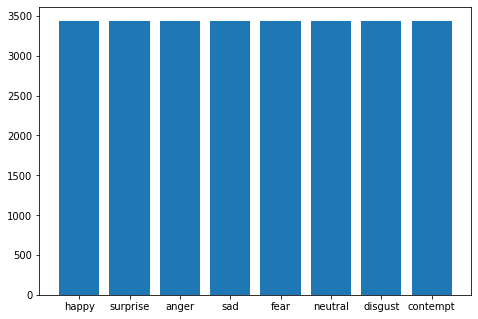

In [184]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT-VFER/train/*")

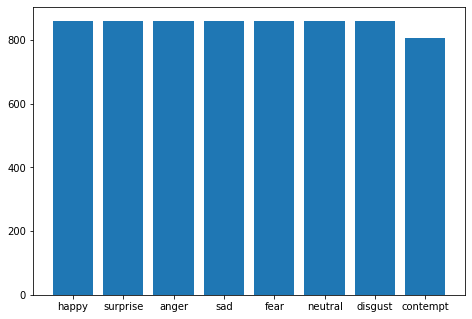

In [185]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT-VFER/val/*")

The amount of data inside the training set is too low to perform well on transformers training. So, we complete this subset using more images from VIT (which are not in the training or validation set) and add a copy to the training set. After that, we need to balance the training set because the initial dataset (ViT) has some classes with a low number of samples (contempt and disgusts classes).

In [186]:
import os

# defines if two list has some elements in commons or not
def common_data(list_one, list_two):
    result = False
    # traverse in the 1st list
    for x in list_one:
        # traverse in the 2nd list
        for y in list_two:
            # if one common
            if x == y:
                print('Val {} is in common'.format(x))
                result = True
    return result

print(common_data([1,2,3,4],[4,5,6,7]))
print(common_data([1,2,3], [4,5,6]))

Val 4 is in common
True
False


In [193]:
# main directories for the listing classes and filenames
val = "/content/drive/MyDrive/Datasets/ViT-VFER/val/"
train = "/content/drive/MyDrive/Datasets/ViT-VFER/train/"
origin = "/content/drive/MyDrive/Datasets/ViT/"

# classes of the dataset (val and train are the same)
_class_vfer = os.listdir(val)

# final list of listnames for val and train subset
val_listname = {}
train_listname = {}

for cl in _class_vfer:
  val_cl = os.listdir(val + cl)
  train_cl = os.listdir(train + cl)
  if common_data(val_cl, train_cl):
    print('Error - Some elements in common, wrong splitting')
  else:
    val_listname[cl] = val_cl
    train_listname[cl] = train_cl

for cl in _class_vfer:
  if common_data(val_listname[cl], train_listname[cl]):
    print('TRUE: Class {} has some elements in common'.format(cl))
    break
  else: 
    print('FALSE: Class {} has not elements in common'.format(cl))

FALSE: Class happy has not elements in common
FALSE: Class surprise has not elements in common
FALSE: Class anger has not elements in common
FALSE: Class sad has not elements in common
FALSE: Class fear has not elements in common
FALSE: Class neutral has not elements in common
FALSE: Class disgust has not elements in common
FALSE: Class contempt has not elements in common


In [191]:
# actually, we have the list of filenames for current validation and training set 
# so, we need to complete the training set with the remaining ViT files

import shutil

for cl in _class_vfer:
  counter = 0
  for el in glob.glob(origin + cl + "/*"):
    if os.path.basename(el) in val_listname[cl]:
      pass
    else:
      if os.path.basename(el) in train_listname[cl]:
        # do nothing because it is already inside
        pass
      else:
        counter += 1
        shutil.copyfile(el, os.path.join(train, cl, os.path.basename(el)))
  print("Counter for {} class is {}".format(cl, counter))

Counter for happy class is 10392
Counter for surprise class is 5493
Counter for anger class is 6307
Counter for sad class is 7273
Counter for fear class is 6402
Counter for neutral class is 7424
Counter for disgust class is 723
Counter for contempt class is 54


In [194]:
def rename_files(path):
  if os.path.isdir(path):
    classes_list = iw.counter_samples_on_class(path)
    if len(classes_list.keys()) != 0:
      for class_ in classes_list.keys():
         counter_element = classes_list[class_]
         counter = 0
         print(path)
         print(class_)
         print(glob.glob(path + "/*.jpg"))
         for file in glob.glob(path +  "/*.jpg"):
           print(f'Renaming {file} to {os.path.join(path, str(counter) + ".jpg")}')
           os.rename(file, os.path.join(path, str(counter) + ".jpg"))
           counter +=1
      return 0
  else:
      return -1

In [195]:
base_path = "/content/drive/MyDrive/Datasets/ViT-VFER/train"
classes_ = iw.counter_samples_on_class(base_path + "/*")
for val in classes_.keys():
  rename_files(os.path.join(base_path, val))

Streaming output truncated to the last 5000 lines.
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1888.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/2435.jpg
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1889.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/2436.jpg
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1890.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/2437.jpg
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1891.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/2438.jpg
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1892.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/2439.jpg
Renaming /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust/resized_on_affect_net_1893.jpg to /content/drive/MyDrive/Datasets/ViT-VFER/

This phase obtained the aim to divide the dataset in training and validation subset for the transformer submission. Now, we can pre-process data and prepare dataset for training phase.

## 5. Data Pre-processing

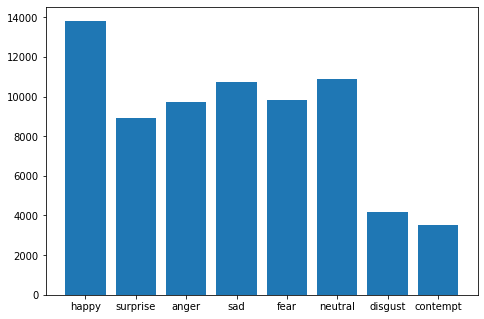

In [196]:
plot_dataset("/content/drive/MyDrive/Datasets/ViT-VFER/train/*")

In the pre-processing phase, we will do the data augmentation; it is the phase where we will improve the total number of images for categories with a small number of samples and define a final balanced version of the ViT dataset.

In [200]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generator(path, 
              format_img, 
              dest_path,
              starting_counter=0, 
              num_augment=1, 
              zoom_range=0.6, 
              brightness_range=(0.2,0.8),
              ):
   """generator void

    Args:
      path (str): The source path of the images folder 
      format_img (str): Extension of the image to augment
      dest_path (str): Destination path for the augmented samples
      starting_counter (int): Counter of the namespace to define the augmented elements, default 1
      num_augment (int): Number of augment samples for each image
      zoom_range (float): Range value for the zooming augmentation
      brightness_range (tuple): Range of brightness augmentation
      width_shift_range (float): Augment shifting on width
      height_shift_range (height): Augment shifting on height
      rotation_range (float): Rotation degree for rotation augmentation
    """    
   gen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            brightness_range=brightness_range,
            zoom_range=zoom_range,
            horizontal_flip=True
            )
   print(f'Data Augmentation parameters:\nZoom Range: {zoom_range}\nBrighness Range: {brightness_range}\n')
   if iw.navigate_path(dest_path) == 0:
      os.mkdir(dest_path)
   num_el = iw.navigate_path(dest_path)
   c = starting_counter
   print('Starting generation...')
   for file in glob.glob(path + "/*." + format_img):
      img = cv2.imread(file)
      # convert to numpy array
      # expand dimension to one sample
      samples = np.expand_dims(img, 0)
      iterator = gen.flow(samples, batch_size=1)
      for i in range(0, num_augment):
          batch = iterator.next()
          image = batch[0].astype('uint8')
          cv2.imwrite(dest_path + "augmented_on_" + str(num_el) + "_" + str(c) + "."+ format_img, image)
          c += 1
   print(f'Data Augmentation for the {path} is done!')


The data augmentation will balance the dataset, so we do not need to set it up for each class but only for categories with few samples. According to the data analysis, we obtained some vital information about the ViT dataset, and it has disgust and contempt classes with the smallest number of data. So, we will operate data augmentation only on samples categorized as one of these two categories.

In [231]:
def augm_select(limit):

  augm_class = []

  for class_ in classes:
    if categories_data[class_]['jpg_count'] < limit:
      augm_class.append(class_)
  return augm_class

augm_class = augm_select(5000)

In [207]:
for class_ in augm_class:
  generator("/content/drive/MyDrive/Datasets/ViT-VFER/train/" + class_, "jpg", "/content/drive/MyDrive/Datasets/ViT-VFER/train/" + class_ + "/", 0, num_augment=2)

Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/contempt is done!


In [234]:
augm_class = augm_select(13000)
for class_ in augm_class:
  generator("/content/drive/MyDrive/Datasets/ViT-VFER/train/" + class_, "jpg", "/content/drive/MyDrive/Datasets/ViT-VFER/train/" + class_ + "/", 0, num_augment=1)

Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/surprise is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/anger is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/sad is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/fear is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/neutral is done!
Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...
Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/t

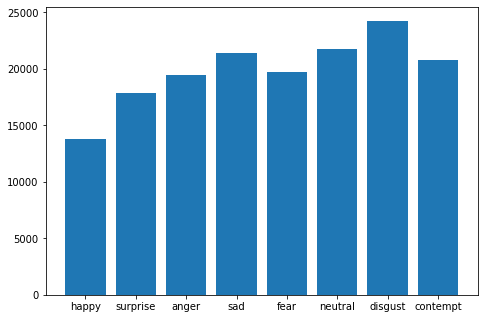

In [235]:
train_path = "/content/drive/MyDrive/Datasets/ViT-VFER/train/*"
plot_dataset(train_path)

In [236]:
generator("/content/drive/MyDrive/Datasets/ViT-VFER/train/" + "happy", "jpg", "/content/drive/MyDrive/Datasets/ViT-VFER/train/" + "happy" + "/", 0, num_augment=1)

Data Augmentation parameters:
Zoom Range: 0.6
Brighness Range: (0.2, 0.8)

Starting generation...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Data Augmentation for the /content/drive/MyDrive/Datasets/ViT-VFER/train/happy is done!


In [237]:
vit_tot = iw.counter_samples(train_path)
print('The total number of samples now is:', vit_tot)

The total number of samples now is: 172952


In [238]:
iw.counter_samples_on_class(train_path)

{'anger': 19500,
 'contempt': 20766,
 'disgust': 24288,
 'fear': 19690,
 'happy': 27670,
 'neutral': 21734,
 'sad': 21432,
 'surprise': 17872}

Finally, we have a balanced dataset where, for each class, we have at least 9500 different samples. The total amount of data is 101217. During the training phase, dataset we will split into training and validation sets in a homogeneous way to maintain consistency of the class variance. The last thing to do in this section is to adapt the .png to the .jpg format; this will make ViT consistent on the number, size and extension.

In [226]:
dataset_path = "/content/drive/MyDrive/Datasets/ViT-VFER/"
classes_list = iw.list_classes(dataset_path + "train/" + "*")
from_extension = "png"
to_extension = "jpg"
for st in ['train/', 'val/']:
  for el in classes_list:
    print(f'Converting images on {el} class from .{from_extension} to .{to_extension} extension in {dataset_path}{st}{el}')
    iw.extension_converter(dataset_path + st + el, from_extension, to_extension, dataset_path + st + el)

Converting images on happy class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/happy
Converting images on surprise class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/surprise
Converting images on anger class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/anger
Converting images on sad class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/sad
Converting images on fear class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/fear
Converting images on neutral class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/neutral
Converting images on disgust class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/disgust
Converting images on contempt class from .png to .jpg extension in /content/drive/MyDrive/Datasets/ViT-VFER/train/contempt
Converting images on happy class from .png to .jpg

In [239]:
categories_data = {}
for class_ in classes:
  categories_data[class_] = {}
  categories_data[class_]["png_count"] = iw.counter_file_extension(train_path[0: len(train_path) - 1] + class_, "png")
  categories_data[class_]["jpg_count"] = iw.counter_file_extension(train_path[0: len(train_path) - 1] + class_, "jpg")
categories_data

{'anger': {'jpg_count': 19500, 'png_count': 0},
 'contempt': {'jpg_count': 20766, 'png_count': 0},
 'disgust': {'jpg_count': 24288, 'png_count': 0},
 'fear': {'jpg_count': 19690, 'png_count': 0},
 'happy': {'jpg_count': 27670, 'png_count': 0},
 'neutral': {'jpg_count': 21734, 'png_count': 0},
 'sad': {'jpg_count': 21432, 'png_count': 0},
 'surprise': {'jpg_count': 17872, 'png_count': 0}}

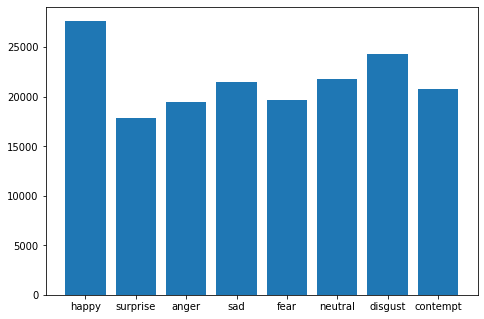

In [240]:
plot_dataset(train_path)

ViT Dataset is now composed only of jpg images with 224x224 dimensions, with three channels values (RGB) and in a balanced number of samples per class and splitted in training and validation set.

## 6. Training Transformer

In [241]:
!pip install timm

In [242]:
import timm, torch
from torchvision import datasets, models, transforms

input_size = (224,224)
batch_size = 60

data_dir= "/content/drive/MyDrive/Datasets/ViT-VFER/"

In [243]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [244]:
from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [245]:
NUM_CLASSES = 8
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [247]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [248]:
model.head = nn.Linear(768, NUM_CLASSES)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [249]:
import pickle, sys

def save_history(history, filename):
  if os.path.isfile(filename):
    os.remove(filename)
  file_handler = open(filename + ".pkl", "wb")
  pickle.dump(history, file_handler)
  file_handler.close()


def load_history(filename):
  file_handler = open(filename + ".pkl", "rb")
  output = pickle.load(file_handler)
  file_handler.close()
  return output


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, 
                is_loaded = False, load_state_ws=None, history_file_acc="history_accuracy",
                history_file_loss="history_loss", n_partial=0, model_folder=""):
    
    history = {'val' : [], 'train' : []}
    loss_history = {'val' : [], 'train' : []}

    if is_loaded and load_state_ws != None:
      # load the model
      model = torch.load(load_state_ws)
      model.eval()
      print('Model loaded correctly')
      history = load_history(history_file_acc)
      loss_history = load_history(history_file_loss)
      print('History loaded')

    
    print('Starting Training')
    print('-' * 12)

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_since = time.time()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 12)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            total = len(dataloaders[phase])
            current = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            dl = dataloaders[phase]
            totalIm=0
            # Iterate over data.
            for inputs, labels in dl:
                totalIm+=len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                      if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / totalIm
                epoch_acc = running_corrects.double() / totalIm
                # status update
                current += 1

                sys.stdout.write("\r" + f"{epoch + 1}/{num_epochs} - {phase} step : " + str(current * batch_size) + "/" +  str(total * batch_size) + " - " + 
                                 "{}_accuracy : ".format(phase) + "{:4f}".format(epoch_acc) + " - {}_loss : ".format(phase) + "{:4f}".format(epoch_loss))
                sys.stdout.flush()

                
              
            epoch_loss = running_loss / totalIm
            epoch_acc = running_corrects.double() / totalIm
            print() # avoid result cleaning 
            if phase == 'train':
              history['train'].append(epoch_acc)
              loss_history['train'].append(epoch_loss)

            # deep copy the model only in case the accusary is better in evaluation (local optima)
            local_optima = False
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                local_optima = True
            if phase == 'val':
                history['val'].append(epoch_acc)
                loss_history['val'].append(epoch_loss)
        
        interval_epoch = time.time() - epoch_since 
        print('\nEpoch {} complete in. {:.0f}m {:.0f}s {}'.format(epoch + 1, interval_epoch // 60, interval_epoch % 60, "with best local accuracy" if local_optima else ""))
        save_history(loss_history, model_folder + os.path.basename(model_folder) + "_" + history_file_loss)
        torch.save(model.state_dict(), model_folder + "epoch_{}_{}".format(epoch + 1, os.path.basename(model_folder[:len(model_folder) - 1])))
        print("-" * 12)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history['train'], history['val']

In [250]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)
feature_extract=False

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

for name,param in model.named_parameters():
    if param.requires_grad == True:
          print("\t",name)

# stochasic gradient descent
lr_in = 0.001
momentum_in = 0.9
optimizer_ft = optim.SGD(params_to_update, lr=lr_in, momentum=momentum_in)

cuda:0
Params to learn:
	 cls_token
	 pos_embed
	 patch_embed.proj.weight
	 patch_embed.proj.bias
	 blocks.0.norm1.weight
	 blocks.0.norm1.bias
	 blocks.0.attn.qkv.weight
	 blocks.0.attn.qkv.bias
	 blocks.0.attn.proj.weight
	 blocks.0.attn.proj.bias
	 blocks.0.norm2.weight
	 blocks.0.norm2.bias
	 blocks.0.mlp.fc1.weight
	 blocks.0.mlp.fc1.bias
	 blocks.0.mlp.fc2.weight
	 blocks.0.mlp.fc2.bias
	 blocks.1.norm1.weight
	 blocks.1.norm1.bias
	 blocks.1.attn.qkv.weight
	 blocks.1.attn.qkv.bias
	 blocks.1.attn.proj.weight
	 blocks.1.attn.proj.bias
	 blocks.1.norm2.weight
	 blocks.1.norm2.bias
	 blocks.1.mlp.fc1.weight
	 blocks.1.mlp.fc1.bias
	 blocks.1.mlp.fc2.weight
	 blocks.1.mlp.fc2.bias
	 blocks.2.norm1.weight
	 blocks.2.norm1.bias
	 blocks.2.attn.qkv.weight
	 blocks.2.attn.qkv.bias
	 blocks.2.attn.proj.weight
	 blocks.2.attn.proj.bias
	 blocks.2.norm2.weight
	 blocks.2.norm2.bias
	 blocks.2.mlp.fc1.weight
	 blocks.2.mlp.fc1.bias
	 blocks.2.mlp.fc2.weight
	 blocks.2.mlp.fc2.bias
	 blocks

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
num_epochs = 5

# model general info
name_model = "vfer_small_5"
base_dir = "/content/drive/MyDrive/Models/"

def mkdir_model(base_dir, name_model, counter):
  try:
    d = "{}/{}".format(base_dir,name_model)
    os.mkdir(d)
  except FileExistsError:
    counter += 1
    mkdir_model(base_dir, str(name_model) + "_" + str(counter), counter)

mkdir_model(base_dir, name_model, 0)

# model files for saving history and model data
model_folder = base_dir + name_model + "/"
model_file = model_folder + name_model + ".pth"
train_history = model_folder + name_model + "_" + "history_train"
val_history = model_folder + name_model + "_" + "history_val"

# Train and evaluate
model, train_hist, val_hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, 
                                          is_inception=False, is_loaded=False, model_folder=model_folder)


#Saving the updated model for the inference phase
torch.save(model.state_dict(), model_file)

# Save histories data
save_history(train_hist, train_history)
save_history(val_hist, val_history)

Starting Training
------------
Epoch 1/5
------------
1/5 - train step : 3900/172980 - train_accuracy : 0.315641 - train_loss : 1.922799

## 7. Evaluation

In this section, we will evaluate the performances of our model based on the accuracy and loss values on the training and validation set with some histograms for the progress analysis during the training phase. 

(0.0, 1.0)

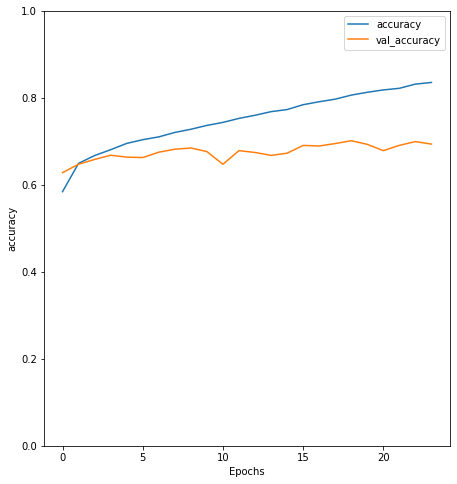

In [ ]:
# plot and data management functions

def plot_graphs(train, val, metric):
    plt.plot(train)
    plt.plot(val, '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

def tensor_to_list(tensor_list):
  l = []
  for el in tensor_list:
    l.append(el.item())
  return l

# model info for the evaluation
name_model = "vfer_small_5"
base_dir = "/content/drive/MyDrive/Models/"
model_folder = base_dir + name_model + "/"

# accuracy plot
_train = load_history(model_folder + name_model + "_history_train")
_val = load_history(model_folder + name_model + "_history_val")
l_train = tensor_to_list(_train)
l_val = tensor_to_list(_val)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(l_train, l_val, 'accuracy')
plt.ylim(0, 1)

(0.0, 0.0253303)

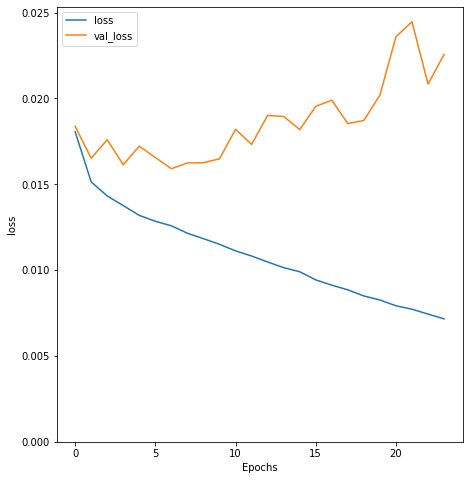

In [ ]:
# loss plot
_loss = load_history(base_dir + name_model + "/" + name_model + "_history_loss")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(_loss['train'], _loss['val'], 'loss')
plt.ylim(0, None)